# Import Packages

In [2]:
import numpy as np
import pandas as pd
import math, random, time, collections
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Load Data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


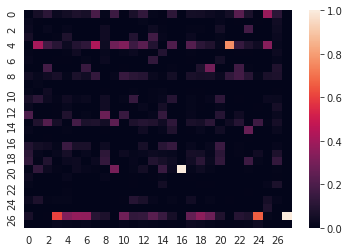

In [3]:
M = np.zeros(shape=([28, 28]))
with open("data/letter_transition_matrix.csv", "r") as f:
    lines = f.readlines()
    assert len(lines)==28, "The size of the alphabet is 28"
    for i in range(28):
        M[i, :] = [float(x) for x in lines[i].split(",")]
logM = np.log(M) # 0 exists
sns.heatmap(M)
# plt.savefig("transition.pdf")

In [4]:
x, y = np.where(logM==-float('inf'))
unique, counts = np.unique(y, return_counts=True)
for i, v in dict(zip(unique, counts)).items():
    if v==27:
        print(i)

27


In [6]:
P = np.zeros(shape=([28]))
with open("data/letter_probabilities.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    P = [float(x) for x in line[:-1].split(",")]
logP = np.log(P)
logP

array([-2.74406395, -4.38811834, -3.9830586 , -3.3385973 , -2.29960929,
       -4.01201128, -4.13061131, -2.98854679, -2.88517691, -6.88957533,
       -5.15651086, -3.46192543, -3.77947318, -2.87297517, -2.77598578,
       -4.357324  , -7.0068771 , -3.03101449, -3.0011987 , -2.65164984,
       -3.77174282, -4.80810333, -3.93312995, -6.72116167, -4.01909939,
       -8.05087363, -1.67694606, -4.68483536])

In [7]:
with open("data/alphabet.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    Alphabet = line[:-1].split(",")
    content2idx = {}
    idx2content = {}
    for i in range(28):
        content2idx[Alphabet[i]] = i
        idx2content[i] = Alphabet[i]

In [8]:
with open("test_ciphertext_breakpoint.txt", "r") as f:
    ciphertext = f.read()[:-1] # replace \n at the end of the file
ciphertext
with open("test_plaintext.txt", "r") as f:
    plaintext = f.read()[:-1] # replace \n at the end of the file
plaintext

'chapter i well prince so genoa and lucca are now just family estates of the buonapartes. but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have frightened yousit down and tell me all the news. it was in july and the speaker was the wellknown anna pavlovna scherer maid of honor and favorite of the empress marya fedorovna. with these words she greeted prince vasili kuragin a man of high rank and importance who was the first to arrive at her reception. anna pavlovna had had a cough for some days. she was as she said suffering from la grippe grippe being then a new word in st. petersburg used only by the elite. all her invitations without exception written in french and delivered by a scarletliveried footman that morning ran a

The char after "." must be " ". We can't have two adjacent "." or " "

# MCMC
Store the ciphering function as a dictionary.

In [103]:
class MCMC:
    def __init__(self, ciphertext, answer):
        self.alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.']
        self.answer = answer
        self.idx2alpha = dict(zip(range(28), self.alphabet))
        random.shuffle(self.alphabet)
        self.cur_f = dict(zip(self.alphabet, range(28)))
        self.ciphertext_transition = collections.Counter()
        for a in self.alphabet:
            self.ciphertext_transition[a] = collections.Counter()
        for i in range(1, len(ciphertext), 1): #including /n
            self.ciphertext_transition[ciphertext[i]][ciphertext[i-1]] += 1
        self.ciphertext = ciphertext
        self.set1, self.set2 = self.checkvalid(self.ciphertext)
        
    def Pf(self, code2idx):
        logPf = logP[code2idx[self.ciphertext[0]]]
        for a in self.alphabet:
            for b in self.alphabet:
                if self.ciphertext_transition[a][b]!=0:
                    if logM[code2idx[a], code2idx[b]] == -math.inf:
                        return "not exist"
                    else:
                        logPf += self.ciphertext_transition[a][b] * logM[code2idx[a], code2idx[b]]
        
        return logPf
    
    def generate_f(self, oldf, set1, set2):
        # set1: "."
        # set2 : " "
        a, b = random.sample(self.alphabet, 2)
        f2 = oldf.copy()
        f2[a] = self.cur_f[b]
        f2[b] = self.cur_f[a]
        for i, v in f2.items():
            if(v==27 and i not in self.set1):
                candidate = random.sample(self.set1, k=1)[0]
                tmp = f2[i]
                f2[i] = f2[candidate]
                f2[candidate] = tmp
            if(v==26 and i not in self.set2):
                candidate = random.sample(self.set2, k=1)[0]
                tmp = f2[i]
                f2[i] = f2[candidate]
                f2[candidate] = tmp
        return f2

    
    def decode(self):
        s = ""
        for c in self.ciphertext:
            s += self.idx2alpha[self.cur_f[c]]
        return s


    def accuracy(self, answer):
        s = 0
        assert len(self.ciphertext)==len(answer), "answer length not align"
        for c in range(len(self.ciphertext)):
            if (self.idx2alpha[self.cur_f[self.ciphertext[c]]]==answer[c]):
                s += 1
#         print("Accuracy {}/{}".format(s, len(self.ciphertext)))
        return s
        
    def checkvalid(self, content):
        transition = collections.Counter()
        for i in self.alphabet:
            transition[i] = collections.Counter()
        for i in range(1, len(content), 1): #including /n
            transition[content[i-1]][content[i]] += 1
        
        valid = False
        
        notrepeat = [] # ' ' & '.'
        for a in self.alphabet:
            if(transition[a][a]==0):
                notrepeat.append(a)
                
        set1 = [] # " "
        set2 = [] # "."
        for a in notrepeat:
            if(len(transition[a])==0):
                set2.append(a)
            elif(len(transition[a])==1 and list(transition[a].keys())[0] in notrepeat):
                set1.append(list(transition[a].keys())[0])
                set2.append(a)
                
        if(len(transition)==28): # All the char have occurred. So we must have a ". " pair.
            return set2, set1
        else:
            return set2, notrepeat
    
    def run(self, runningtime=30, printacc=True):
        n = len(self.ciphertext)
        start_time = time.time()
        loglikelihood = []
        times = []
        acc = []
        accepted = []
        t = 0
        while(time.time()-start_time<runningtime):
            t += 1
            f2 = self.generate_f(self.cur_f, self.set1, self.set2)
            pf2 = self.Pf(f2)
            pf1 = self.Pf(self.cur_f)
            rand = random.random()
            if pf1=="not exist" and pf2=="not exist":
                if random.random()<0.5:
                    accepted.append(True)
                    self.cur_f= f2
                else:
                    accepted.append(False)
            elif pf1=="not exist":
                accepted.append(True)
                self.cur_f = f2
            elif pf2=="not exist":
                accepted.append(False)
                pass
            
            elif rand<min(1, np.exp(pf2-pf1)):
                self.cur_f = f2
                accepted.append(True)
                
            else:
                accepted.append(False)
                
    
            if self.Pf(self.cur_f) != "not exist":
                times.append(t)
                loglikelihood.append(self.Pf(self.cur_f))
                acc.append(self.accuracy(self.answer)/len(self.ciphertext))
            else:
                times.append(math.nan)
                loglikelihood.append(math.nan)
                acc.append(math.nan)
                
            if printacc:
                if (t%500==0):
                    print("Accuracy {}/{}, Log-Liklihood {}, time {} ({}/{})".format(self.accuracy(self.answer), len(self.answer), self.Pf(self.cur_f), time.time()-start_time, t, n))
        return times, loglikelihood, acc, accepted

In [104]:
random.seed(21)
mcmc1 = MCMC(ciphertext=ciphertext[:1119+1], answer=plaintext[:1119+1])
times, loglikelihood, acc, accepted = mcmc1.run(30)
single_f1 = mcmc1.cur_f

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: overflow encountered in exp


Accuracy 546/1120, Log-Liklihood -3455.4584587472777, time 1.4392330646514893 (500/1120)
Accuracy 734/1120, Log-Liklihood -3301.930386570587, time 2.9157588481903076 (1000/1120)
Accuracy 816/1120, Log-Liklihood -3047.7576792371815, time 4.504192113876343 (1500/1120)
Accuracy 866/1120, Log-Liklihood -2963.5578306528328, time 5.7778260707855225 (2000/1120)
Accuracy 1060/1120, Log-Liklihood -2740.858560916313, time 7.053124904632568 (2500/1120)
Accuracy 1096/1120, Log-Liklihood -2685.5368009962817, time 8.418115139007568 (3000/1120)
Accuracy 1118/1120, Log-Liklihood -2684.1232031838244, time 9.783071041107178 (3500/1120)
Accuracy 1118/1120, Log-Liklihood -2684.1232031838244, time 11.050993919372559 (4000/1120)
Accuracy 1098/1120, Log-Liklihood -2687.1265271089824, time 12.346785068511963 (4500/1120)
Accuracy 1098/1120, Log-Liklihood -2687.1265271089824, time 13.688600063323975 (5000/1120)
Accuracy 1118/1120, Log-Liklihood -2684.1232031838244, time 15.040388107299805 (5500/1120)
Accuracy 1

In [53]:
mcmc1.decode()

'chapter i well prince so genoa and lucca are now just family estates of the buonapartes. but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really belieke he is antichristi will hake nothing more to do with you and you are no longer my friend no longer my faithful slake as you call yourself but how do you do i see i hake frightened yousit down and tell me all the news. it was in july and the speaver was the wellvnown anna paklokna scherer maid of honor and fakorite of the empress marya fedorokna. with these words she greeted prince kasili vuragin a man of high ranv and importance who was the first to arrike at her reception. anna paklokna had had a cough for some days. she was as she said suffering from la grippe grippe being then a new word in st. petersburg used only by the elite. all her inkitations without exception written in french and delikered by a scarletlikeried footman that morning ran a

In [56]:
random.seed(21)
mcmc2 = MCMC(ciphertext=ciphertext[1137:], answer=plaintext[1137:])
times, loglikelihood, acc, accepted = mcmc2.run()
single_f2 = mcmc2.cur_f

Accuracy 311/4150, Log-Liklihood not exist, time 0.002104043960571289 (0/5000)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in exp


Accuracy 3357/4150, Log-Liklihood -11451.902934245694, time 2.0423688888549805 (500/5000)
Accuracy 3828/4150, Log-Liklihood -10074.757654918645, time 3.9716427326202393 (1000/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 5.8404059410095215 (1500/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 7.812578916549683 (2000/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 9.73538875579834 (2500/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 11.669350862503052 (3000/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 13.603855848312378 (3500/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 15.4690260887146 (4000/5000)
Accuracy 4147/4150, Log-Liklihood -9832.509696653211, time 17.398634910583496 (4500/5000)


In [57]:
mcmc2.decode()

'ble i shall be very charmed to see you tonight between and annette scherer. heavens what a virulent attack replied the prince not in the least disconcerted by this reception. he had qust entered wearing an embroidered court uniform knee breeches and shoes and had stars on his breast and a serene expression on his flat face. he spoke in that refined french in which our grandfathers not only spoke but thought and with the gentle patronizing intonation natural to a man of importance who had grown old in society and at court. he went up to anna pavlovna kissed her hand presenting to her his bald scented and shining head and complacently seated himself on the sofa. first of all dear friend tell me how you are. set your friends mind at rest said he without altering his tone beneath the politeness and affected sympathy of which indifference and even irony could be discerned. can one be well while suffering morally can one be calm in times like these if one has any feeling said anna pavlovna.

# MCMC B

In [89]:
class MCMC_B:
    def __init__(self, ciphertext, answer, f1=None, f2=None):
        self.answer = answer
        alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.']
        self.idx2alpha = dict(zip(range(28), alphabet))
        self.alphabet = alphabet
        self.ciphertext_transition = collections.Counter()
        for a in self.alphabet:
            self.ciphertext_transition[a] = collections.Counter()
        for i in range(1, len(ciphertext), 1): #including /n
            self.ciphertext_transition[ciphertext[i]][ciphertext[i-1]] += 1
        self.ciphertext = ciphertext
        
        self.cur_f1 = f1
        self.cur_f2 = f2
        
        if(self.cur_f1==None or self.cur_f2==None):
            if(self.cur_f1==None):
                random.shuffle(alphabet)
                self.cur_f1 = dict(zip(alphabet, range(28)))
            if(self.cur_f2==None):
                random.shuffle(alphabet)
                self.cur_f2 = dict(zip(alphabet, range(28)))
            self.cur_f1, self.cur_f2, self.breakpoint = self.generate_f()
            
        l = 0
        r = len(self.ciphertext)-1
        # [minb, maxb]
        # determining the maximum x such that ciphertext[:x] valid
        while(l<=r):
            m = int(l + (r - l)/2)
            a, b = self.checkvalid(self.ciphertext[m:])
            if(len(a)>0 and len(b)>1):
                r = m - 1
            else:
                l = m + 1
        self.minbs = l
        self.leftsets = self.checkvalid(self.ciphertext[:self.minbs])
        
        l = 0
        r = len(self.ciphertext)-1
        # [minb, maxb]
        # determining the minimum x such that ciphertext[x:] valid
        while(l<=r):
            m = int(l + (r - l)/2)
            a, b = self.checkvalid(self.ciphertext[:m])
            if(len(a)>0 and len(b)>1):
                l = m + 1
            else:
                r = m - 1
        self.maxbs = r
        self.rightsets = self.checkvalid(self.ciphertext[self.maxbs:])
        
        self.breakpoint = random.randint(self.minbs, self.maxbs+1)
        
        print("Breakpoints", self.minbs, self.maxbs)
        print(self.leftsets)
        print(self.rightsets)
        
        
        
    def Pf(self, code2idx1, code2idx2, breakpoint):
        logPf1 = logP[code2idx1[ciphertext[0]]]
        for idx in range(1, breakpoint, 1):
            if logM[code2idx1[self.ciphertext[idx]], code2idx1[self.ciphertext[idx-1]]] == -float('inf'):
                logPf1 = "not exist"
                break
            else:
                logPf1 += logM[code2idx1[self.ciphertext[idx]], code2idx1[self.ciphertext[idx-1]]]

        logPf2 = logP[code2idx2[ciphertext[breakpoint]]]
        for idx in range(breakpoint+1, len(self.ciphertext), 1):
            if logM[code2idx2[self.ciphertext[idx]], code2idx2[self.ciphertext[idx-1]]] == -float('inf'):
                logPf2 = "not exist"
                break
            else:
                logPf2 += logM[code2idx2[self.ciphertext[idx]], code2idx2[self.ciphertext[idx-1]]]
        return logPf1, logPf2
    
    def generate_f(self):
        new_b = int(np.random.normal(loc=self.breakpoint, scale=10))
        new_b = max(new_b, self.minbs)
        new_b = min(new_b, self.maxbs)
        
        a, b = random.sample(self.alphabet, 2)
        new_f1 = self.cur_f1.copy()
        new_f1[a] = self.cur_f1[b]
        new_f1[b] = self.cur_f1[a]

        new_f2 = self.cur_f2.copy()
        new_f2[a] = self.cur_f2[b]
        new_f2[b] = self.cur_f2[a]


#         new_b = random.randint(max(self.minbs, self.breakpoint-10), min(self.maxbs, self.breakpoint+10))

        for i, v in new_f1.items():
            if(v==27 and i not in self.leftsets[0]):
                candidate = random.sample(self.leftsets[0], k=1)[0]
                tmp = new_f1[i]
                new_f1[i] = new_f1[candidate]
                new_f1[candidate] = tmp
            if(v==26 and i not in self.leftsets[1]):
                candidate = random.sample(self.leftsets[1], k=1)[0]
                tmp = new_f1[i]
                new_f1[i] = new_f1[candidate]
                new_f1[candidate] = tmp
        for i, v in new_f2.items():
            if(v==27 and i not in self.rightsets[0]):
                candidate = random.sample(self.rightsets[0], k=1)[0]
                tmp = new_f1[i]
                new_f1[i] = new_f1[candidate]
                new_f1[candidate] = tmp
            if(v==26 and i not in self.rightsets[1]):
                candidate = random.sample(self.rightsets[1], k=1)[0]
                tmp = new_f1[i]
                new_f1[i] = new_f1[candidate]
                new_f1[candidate] = tmp
        return new_f1, new_f2, new_b

    def checkvalid(self, content):
        transition = collections.Counter()
        for i in self.alphabet:
            transition[i] = collections.Counter()
        for i in range(1, len(content), 1): #including /n
            transition[content[i-1]][content[i]] += 1
        
        valid = False
        
        notrepeat = [] # ' ' & '.'
        for a in self.alphabet:
            if(transition[a][a]==0):
                notrepeat.append(a)
                
        set1 = [] # " "
        set2 = [] # "."
        for a in notrepeat:
            if(len(transition[a])==0):
                set2.append(a)
            elif(len(transition[a])==1 and list(transition[a].keys())[0] in notrepeat):
                set1.append(list(transition[a].keys())[0])
                set2.append(a)
                
        if(len(transition)==28): # All the char have occurred. So we must have a ". " pair.
            return set2, set1
        else:
            return set2, notrepeat
    

            
    
    def decode(self):
        s = ""
        for c in range(self.breakpoint):
            s += self.idx2alpha[self.cur_f1[self.ciphertext[c]]]
        for c in range(self.breakpoint, len(self.ciphertext), 1):
            s += self.idx2alpha[self.cur_f2[self.ciphertext[c]]]
        return s
    
    def accuracy(self, answer):
        s = 0
        assert len(self.ciphertext)==len(answer), "answer length not align"
        for c in range(self.breakpoint):
            if (self.idx2alpha[self.cur_f1[self.ciphertext[c]]]==answer[c]):
                s += 1
        for c in range(self.breakpoint, len(self.ciphertext), 1):
            if (self.idx2alpha[self.cur_f2[self.ciphertext[c]]]==answer[c]):
                s += 1
#         print("Accuracy {}/{}".format(s, len(self.ciphertext)))
        return s
        
    def accept(self, newscore, oldscore):
        accept_bool = False
        if newscore == "not exist" and oldscore == "not exist":
            if random.random()<0.5:
                accept_bool = True
        elif oldscore == "not exist":
            accept_bool = True
        elif newscore == "not exist":
            pass
        elif (newscore-oldscore) > 5: # speed up for np.exp
            accept_bool = True
        elif random.random()<min(1, np.exp(newscore-oldscore)):
            accept_bool = True
        return accept_bool
                
        
        
    def run(self, n=5000, printacc=True):
        start_time = time.time()
        loglikelihood = []
        times = []
        acc = []
        accepted = []
        for t in range(n):
            new_f1, new_f2, new_b = self.generate_f()
            pfnew_f1, pfnew_f2 = self.Pf(new_f1, new_f2, new_b)
            pfold_f1, pfold_f2 = self.Pf(self.cur_f1, self.cur_f2, self.breakpoint)
            
                
            if self.accept(newscore=pfnew_f1, oldscore=pfold_f1):
                self.cur_f1 = new_f1
            if self.accept(newscore=pfnew_f2, oldscore=pfold_f2):
                self.cur_f2 = new_f2
                
            if pfnew_f1 == "not exist" or pfnew_f2 == "not exist":
                pfnew_b = "not exist"
            else:
                pfnew_b = pfnew_f1 * pfnew_f2
            if pfold_f1 == "not exist" or pfold_f2 == "not exist":
                pfold_b = "not exist"
            else:
                pfold_b = pfold_f1 * pfold_f2
            if self.accept(newscore=pfnew_b, oldscore=pfold_b):
                self.breakpoint = new_b
    
            if self.Pf(self.cur_f1, self.cur_f2, self.breakpoint) != "not exist":
                times.append(t)
                loglikelihood.append(self.Pf(self.cur_f1, self.cur_f2, self.breakpoint))
                acc.append(self.accuracy(self.answer)/len(self.ciphertext))
            else:
                times.append(math.nan)
                loglikelihood.append(math.nan)
                acc.append(math.nan)
                
            if printacc:
                if ((t+1)%500==0):
                    print(self.breakpoint)
                    print(self.cur_f1)
                    print(self.cur_f2)
                    print("Accuracy {}/{}, Log-Liklihood {}, time {} ({}/{})".format(self.accuracy(self.answer), len(self.answer), self.Pf(self.cur_f1, self.cur_f2, self.breakpoint), time.time()-start_time, t+1, n))
        return times, loglikelihood, acc, accepted

In [90]:
random.seed(21)
mcmc = MCMC_B(ciphertext=ciphertext, answer=plaintext, f1=single_f1, f2=single_f2)
# mcmc.checkvalid(ciphertext[:1120])
times, loglikelihood, acc, accepted = mcmc.run(n=2000)

Breakpoints 1119 1137
(['b', 'e', 'f', 'y'], ['u', 'z'])
(['d', 'o', 'q'], ['j', 'a'])
1119
{'d': 8, 't': 13, 'e': 16, 'o': 3, 'l': 15, 'i': 5, 'k': 12, 'c': 4, 'b': 25, 'x': 24, 'z': 26, 'r': 1, 'y': 27, 'a': 23, 'm': 11, 'h': 0, 's': 9, '.': 10, 'q': 6, 'v': 14, 'g': 19, 'p': 22, 'j': 18, 'u': 20, ' ': 17, 'w': 7, 'n': 2, 'f': 21}
{'d': 16, 't': 2, 'e': 8, 'o': 27, 'l': 23, 'i': 24, 'k': 17, 'c': 0, 'b': 13, 'x': 18, 'z': 11, 'r': 6, 'y': 12, 'a': 26, 'm': 14, 'h': 5, 's': 15, '.': 19, 'q': 9, 'v': 7, 'g': 3, 'p': 10, 'j': 20, 'u': 4, ' ': 21, 'w': 25, 'n': 1, 'f': 22}
Accuracy 5198/5287, Log-Liklihood (-2742.80689194385, -9908.87325267249), time 14.390286922454834 (500/2000)
1129
{'d': 8, 't': 13, 'e': 16, 'o': 6, 'l': 5, 'i': 15, 'k': 22, 'c': 4, 'b': 25, 'x': 24, 'z': 26, 'r': 1, 'y': 27, 'a': 23, 'm': 11, 'h': 0, 's': 21, '.': 10, 'q': 3, 'v': 14, 'g': 19, 'p': 12, 'j': 18, 'u': 20, ' ': 17, 'w': 7, 'n': 2, 'f': 9}
{'d': 16, 't': 2, 'e': 8, 'o': 27, 'l': 9, 'i': 24, 'k': 17, 'c':

In [91]:
print(mcmc.breakpoint)
mcmc.decode()

1131


'chapter i well prince so genoa and lucca are now just family estates of the vuonapartes. vut i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated vy that antichristi really velieke he is antichristi will hake nothing more to do with you and you are no longer my friend no longer my faithful slake as you call yourself vut how do you do i see i hake frightened yousit down and tell me all the news. it was in july and the speaqer was the wellqnown anna paklokna scherer maid of honor and fakorite of the empress marya fedorokna. with these words she greeted prince kasili quragin a man of high ranq and importance who was the first to arrike at her reception. anna paklokna had had a cough for some days. she was as she said suffering from la grippe grippe veing then a new word in st. petersvurg used only vy the elite. all her inkitations without exception written in french and delikered vy a scarletlikeried footman that morning ran a